In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import path
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


import os
print(os.listdir("../input"))

# read data in pandas dataframe
# df_train =  pd.read_csv('../input/train.csv', nrows = 150000, parse_dates=["pickup_datetime"])
df_train =  pd.read_csv('../input/train.csv', nrows = 50_000, parse_dates=["pickup_datetime"])
'''
print(len(df_train))
print(df_train.dtypes)
'''
df_train.head()

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


**Data Cleaning**

In [2]:
# check and drop the missing values
print(df_train.isnull().sum())
df_train = df_train.dropna(how = 'any', axis = 'rows')

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


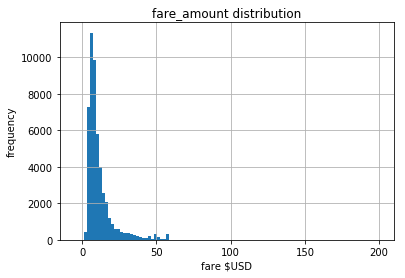

In [3]:
# check for outliers in fare_amount 
df_train["fare_amount"].hist(bins=100)
plt.xlabel('fare $USD')
plt.ylabel('frequency')
plt.title('fare_amount distribution')
'''
print(df_train["fare_amount"].describe())
'''
# the minimal fare_amount is negative, which is not realistic, so drop them
df_train = df_train[df_train.fare_amount>0]

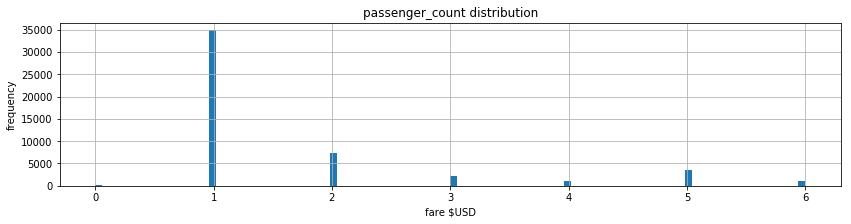

In [4]:
# check for outliers in passenger_count 
df_train["passenger_count"].hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.ylabel('frequency')
plt.title('passenger_count distribution')
'''
print(df_train["passenger_count"].describe())
'''
# passenger_count of zero or larger than 6 (a SUV cab) seems to be not realistic, so drop them
df_train = df_train[(df_train['passenger_count']>0) & (df_train['passenger_count']<=6)]

In [5]:
# Googling latitudes and longitudes give such information
# Latitudes range from -90 to 90.
# Longitudes range from -180 to 180.
'''
print(df_train['pickup_latitude'].describe())
print(df_train['pickup_longitude'].describe())
print(df_train['dropoff_latitude'].describe())
print(df_train['dropoff_longitude'].describe())
'''

# it shows some data errors in latitude and longitude,
# including outliers and wrong order when inserted latitude and longitude into dataset
# by using Google map, the latitude and longitude coordinate of New York City is:
nyc = (40.730610, -73.935242)

# so drop trips that are out of New York City and its nearby areas
def city_nearby_areas(df, city):
    return (df['pickup_longitude'] >= city[1]-1.5) & (df['pickup_longitude'] <= city[1]+1.5) & \
           (df['pickup_latitude'] >= city[0]-1.5) & (df['pickup_latitude'] <= city[0]+1.5) & \
           (df['dropoff_longitude'] >= city[1]-1.5) & (df['dropoff_longitude'] <= city[1]+1.5) & \
           (df['dropoff_latitude'] >= city[0]-1.5) & (df['dropoff_latitude'] <= city[0]+1.5)

df_train = df_train[city_nearby_areas(df_train, nyc)]
print(len(df_train))

48802


In [6]:
# a function to calculate distance between two latitude longitude points.
# this function is based on https://stackoverflow.com/questions/27928/
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...


**Calculate the Distance in Kilometers Between Pickup and Dropoff Position of Each Trip and Check for Outliers**

count    48802.000000
mean         3.383907
std          4.333417
min          0.000000
25%          1.263055
50%          2.159878
75%          3.941914
max        164.874362
Name: distance_km, dtype: float64
47967


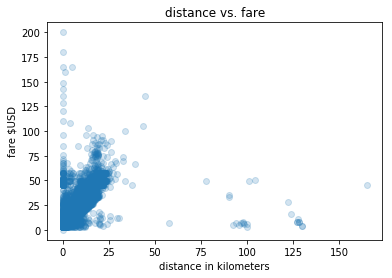

In [7]:
df_train['distance_km'] = df_train.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)

# check for outliers in distance_km 
print(df_train["distance_km"].describe())

plt.scatter(df_train["distance_km"], df_train["fare_amount"], alpha=0.2)
plt.xlabel('distance in kilometers')
plt.ylabel('fare $USD')
plt.title('distance vs. fare')

# the plot shows that some trips have zero distance but non-zero fare
# maybe caused by pickup and dropoff at same place
# drop trips with zero distance since there can not be used to fit model
df_train = df_train[df_train["distance_km"] >= 0.1]
print(len(df_train))

# the plot also shows some long trips but with low fare, just leave them now and I will analyze them later
# df_train[df_train.fare_amount > 50]

Text(0.5,1,'pickup positions')

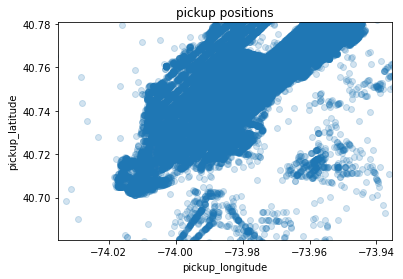

In [8]:
plt.scatter(df_train["pickup_longitude"], df_train["pickup_latitude"], alpha=0.2)
plt.xlim(nyc[1]-0.1, nyc[1])
plt.ylim(nyc[0]-0.05, nyc[0]+0.05)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('pickup positions')

# df_train = df_train[(df_train["distance_km"] < 80)]

In [9]:
'''
contains_point(point, transform=None, radius=0.0):
    Returns whether the (closed) path contains the given point.
cw_path  = path.Path([[0,0], [0,1], [1,2], [3,2], [2,1], [3,0]])
cw_path.contains_point([1.5, 1])
'''

'\ncontains_point(point, transform=None, radius=0.0):\n    Returns whether the (closed) path contains the given point.\ncw_path  = path.Path([[0,0], [0,1], [1,2], [3,2], [2,1], [3,0]])\ncw_path.contains_point([1.5, 1])\n'

**Check If a Taxi Trip is To/From Airport**

Taxi trip between JFK and Manhattan is a flat fare.

Taxi trip to EWR has a Newark Surcharge

In [10]:
# check if a give place (coordinate) is loacted in the specified area
def in_area(area, place):
    p = path.Path(area)
    res = p.contains_point(place)
    return res
# in_area(Manhattan, [40.745969, -74.027072])

In [11]:
# Manhattan area boundary is defined by following coordinates
Manhattan = [(40.686909, -74.034496), (40.680376, -74.021145), (40.704307, -73.997131), (40.709044, -73.974796), \
               (40.745379, -73.962538), (40.771583, -73.938199), (40.773910, -73.939632), (40.780453, -73.935530), \
               (40.780316, -73.924544), (40.795204, -73.910464), (40.802289, -73.927286), (40.810788, -73.933235), \
               (40.835167, -73.934011), (40.873370, -73.906769), (40.879385, -73.910359), (40.875912, -73.915514), \
               (40.882451, -73.934690), (40.755360, -74.014918)]

In [12]:
# Airport trip to/from JFK and any location in Manhattan is a flat fare
# Airport trip from JFK to other New York City destinations is a metered fare
# Airport trip to Newark Liberty International Airport is a metered fare with a Newark Surcharge
# Airport trip to LaGuardia Airport is a metered fare

# check if the trip is between JFK and a location in Manhattan, or the trip dropoff at to Newark Airport,
# dropoff/pickup at the place where is less than 2 km from airport is regarded as trip to/from airport
jfk = (40.6413, -73.7781)
ewr = (40.6895, -74.1745)

def airport_trip(trip):
    if distance(trip["dropoff_latitude"], trip["dropoff_longitude"], jfk[0], jfk[1]) <= 2 and \
    in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True:
        return "jfk_Manhattan"
    elif distance(trip["pickup_latitude"], trip["pickup_longitude"], jfk[0], jfk[1]) <= 2 and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        return "jfk_Manhattan"
    elif distance(trip["dropoff_latitude"], trip["dropoff_longitude"], ewr[0], ewr[1]) <=2:
        return "airport_ewr"
    else:
        return "metered_fare"

df_train["to_airport"] = df_train.apply(lambda row: airport_trip(row), axis=1)


In [13]:
df_train["to_airport"].value_counts()

metered_fare     47232
jfk_Manhattan      669
airport_ewr         66
Name: to_airport, dtype: int64

In [14]:
# using one-hot encoding to transform to_airport feature for fitting regression model 
df_airport = pd.get_dummies(df_train["to_airport"])
df_train = df_train.join(df_airport)

**Extract Hour and Day From pickup_datetime**

Taxi trip at night has extra surcharge.

The amount of traffic also depends on the hour of the day, and it determines the duration of the trip and thus the fare. 

In [15]:
def hour_type(hour, weekday):
    if hour in list(range(20, 25)) + list(range(0,7)):
        return "night"
    elif hour in range(7, 10) and weekday == 1:
        return "morning_peak"
    elif hour in range(16, 20) and weekday == 1:
        return "afternoon_peak"
    else:
        return "normal_hour"

def extract_time(record):
    record['year'] = record["pickup_datetime"].year
    record['month'] = record["pickup_datetime"].month
    record["day_of_week"] = record["pickup_datetime"].weekday()
    record["weekday"] = 1 if record["day_of_week"] in range(0, 5) else 0
    record['hour'] = record["pickup_datetime"].hour
    record["hour_type"] = hour_type(record["hour"], record["weekday"])
    return record


In [18]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,to_airport,...,year,month,day_of_week,weekday,hour,hour_type,afternoon_peak,morning_peak,night,normal_hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,metered_fare,...,2009,6,0,1,17,afternoon_peak,1,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,metered_fare,...,2010,1,1,1,16,afternoon_peak,1,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,metered_fare,...,2011,8,3,1,0,night,0,0,1,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,metered_fare,...,2012,4,5,0,4,night,0,0,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,metered_fare,...,2010,3,1,1,7,morning_peak,0,1,0,0


In [17]:
df_train = df_train.apply(lambda r: extract_time(r), axis=1)

df_hour_type = pd.get_dummies(df_train["hour_type"])
df_train = df_train.join(df_hour_type)

# Another method to find the day of week 
# day_of_week = pd.to_datetime(df_train["pickup_datetime"]).dt.weekday_name
# or
# day_of_week = pd.to_datetime(df_train["pickup_datetime"]).dt.dayofweek

# df_train['hour'] = df_train["pickup_datetime"].apply(lambda t: t.hour)
# df_train['year'] = df_train["pickup_datetime"].apply(lambda t: t.year-2009)
# df_train["day_of_week"] = df_train["pickup_datetime"].apply(lambda t: t.weekday())

ValueError: columns overlap but no suffix specified: Index(['afternoon_peak', 'morning_peak', 'night', 'normal_hour'], dtype='object')

**Check If a Taxi Trip is Group Ride**

Two, three, or four people can take a group ride from a yellow taxi Group Ride Stand and pay a flat rate.

Group Ride pickup times are certain hours, Monday – Friday (excluding holidays).

GR_1:
York Ave / 70th St, Frankfort St / Pearl St & on to World Financial Center, 
$6.00, 6AM – 10AM

GR_2:
Port Authority Bus Terminal, 59th St / 6th Ave, 
$3.00, 6AM– 10AM

GR_3:
LaGuardia Airport - Marine Air Terminal, Bet 35th & 59th St & Bet 2nd Ave & 8th Ave, 
\$22/person with 2 passengers, $18/person with 3 passengers, 7AM – 10AM & 4PM – 8PM

GR_4:
57th St / 8th Ave, 57th St to Park Ave / 42nd St,
$3.00, 6AM– 10AM

GR_5:
72nd St / 3rd Ave, Park Ave / 42nd St,
$4.00, 6AM– 10AM

GR_6:
72nd St / Columbus Ave, Park Ave / 42nd St,
$4.00, 6AM– 10AM


In [19]:
def group_ride_classifier(trip):
    if trip['hour']>=6 and trip['hour']<10 and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.765549, -73.954689) <= 1 and \
    distance(trip["dropoff_latitude"], trip["dropoff_longitude"], 40.709519, -74.001743) <= 1:
        return "GR_1"
    elif trip['hour']>=6 and trip['hour']<10 and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.757083, -73.990731) <= 1 and \
    distance(trip["dropoff_latitude"], trip["dropoff_longitude"], 40.765665, -73.976217) <= 1:
        return "GR_2"
    elif ((trip['hour']>=7 and trip['hour']<10) or (trip['hour']>=16 and trip['hour']<20)) and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.773292, -73.886142) <= 1 and \
    in_area([(40.768587, -73.982130), (40.752864, -73.993228), (40.745326, -73.975283), (40.760704, -73.964072)], [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        return "GR_3"
    elif trip['hour']>=6 and trip['hour']<10 and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.766736, -73.982875) <= 1 and \
    distance(trip["dropoff_latitude"], trip["dropoff_longitude"], 40.752175, -73.977803) <= 1:
        return "GR_4"
    elif trip['hour']>=6 and trip['hour']<10 and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.769756, -73.960591) <= 1 and \
    distance(trip["dropoff_latitude"], trip["dropoff_longitude"], 40.752175, -73.977803) <= 1:
        return "GR_5"
    elif trip['hour']>=6 and trip['hour']<10 and trip['weekday']==1 and trip["passenger_count"] >= 2 and \
    distance(trip["pickup_latitude"], trip["pickup_longitude"], 40.777415, -73.978793) <= 1 and \
    distance(trip["dropoff_latitude"], trip["dropoff_longitude"], 40.752175, -73.977803) <= 1:
        return "GR_6"
    else:
        return "not_group_ride"


In [20]:
df_train['group_ride'] = df_train.apply(lambda row: group_ride_classifier(row), axis=1)
df_train['group_ride'].value_counts()

not_group_ride    47837
GR_2                 51
GR_5                 42
GR_4                 27
GR_6                  6
GR_3                  2
GR_1                  2
Name: group_ride, dtype: int64

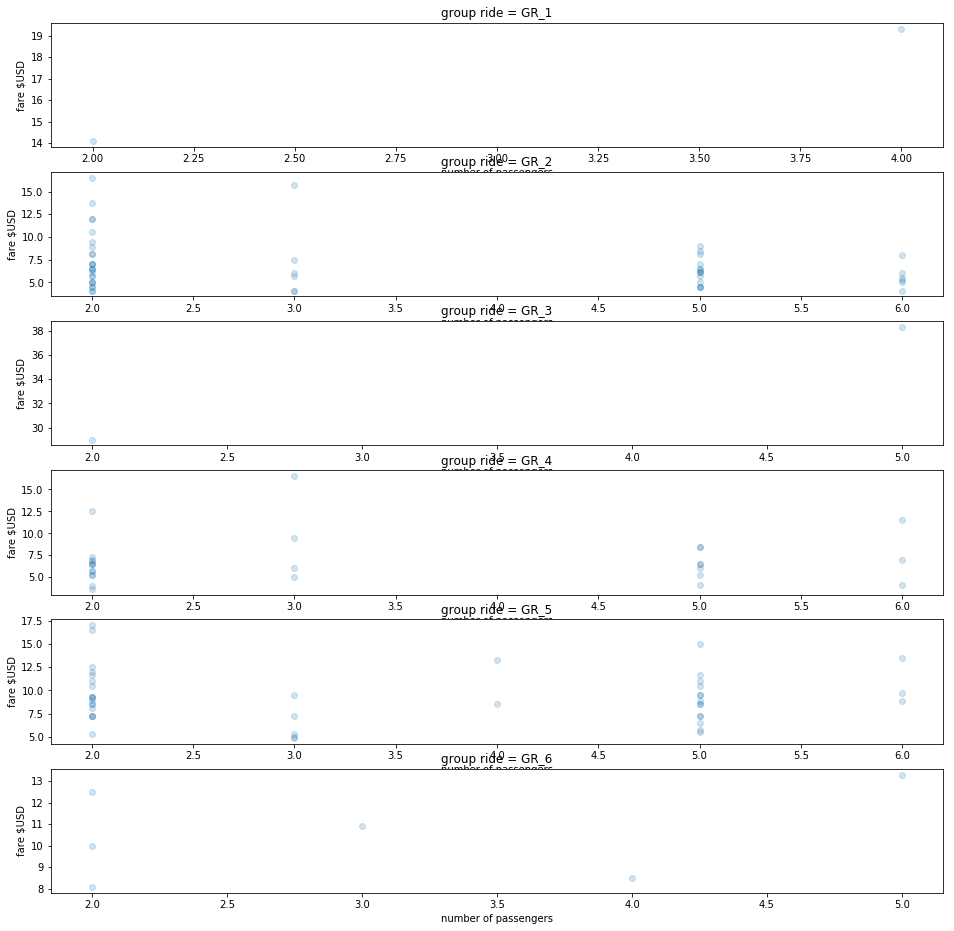

In [21]:
'''
fig, axes = plt.subplots(ncols=1, nrows=6, figsize=(16,16))

for i, group_ride in enumerate(["GR_1", "GR_2", "GR_3", "GR_4", "GR_5", "GR_6"]):
    df_group_ride = df_train[df_train['group_ride'] == group_ride]
    axes[i].scatter(df_group_ride["passenger_count"], df_group_ride["fare_amount"], alpha=0.2)
    axes[i].set_xlabel('number of passengers')
    axes[i].set_ylabel('fare $USD')
    axes[i].set_title('group ride = ' + group_ride)
'''

# in a group ride, fare amount supposed to be linearly dependent on the number of passengers,
# but such trend is not shown in the scatter plots of passenger_count v.s. fare_amount for any group ride

In [ ]:
# df_train[(distance(df_train["pickup_latitude"], df_train["pickup_longitude"], 40.765549, -73.954689) <= 1) & \
#     (df_train['hour']>=6) & (df_train['hour']<10) & (df_train['weekday']==1)][["fare_amount", "pickup_latitude", "pickup_longitude", \
#                                                    "dropoff_latitude", "dropoff_longitude", "passenger_count", "weekday"]]

# df_train[df_train['group_ride'] == "GR_3"][["fare_amount", "pickup_latitude", "pickup_longitude", \
#                                             "dropoff_latitude", "dropoff_longitude", "passenger_count", "weekday"]]

**Check If Trips Crossed Boroughs, Which may Caused Toll Fees to Fare Amount**

Passengers must pay tolls if the trip between New Jersey/Manhattan, Manhattan/Queens+Brooklyn,  Staten Island/Brooklyn and New Jersey/Staten Island

In [22]:
# New Jersey boundary coordinates:
New_Jersey = [(40.998125, -73.892134), (40.752798, -74.011413), (40.652655, -74.046638), (40.643193, -74.152969), \
              (40.647175, -74.181208), (40.631922, -74.203180), (40.557508, -74.219282), (40.549155, -74.247418), \
              (40.521271, -74.246102), (40.509769, -74.258537), (40.475795, -74.237970), (40.484005, -73.955930), \
              (38.760545, -74.169389), (39.065187, -75.640440), (41.927266, -75.595312)]

# Brooklyn and Queens bounday coordinates
Brooklyn_Queens = [(40.686909, -74.034496), (40.680376, -74.021145), (40.704307, -73.997131), (40.709044, -73.974796), \
                   (40.745379, -73.962538), (40.771583, -73.938199), (40.773910, -73.939632), (40.780453, -73.935530), \
                   (40.780316, -73.924544), (40.795204, -73.910464), (40.809220, -73.776494), (40.752348, -73.700726), \
                   (40.545962, -73.741831), (40.531383, -74.053978)]

# Staten Island boundary coordinates:
Staten_Island = [(40.652655, -74.046638), (40.643193, -74.152969), (40.647175, -74.181208), (40.631922, -74.203180), \
                 (40.557508, -74.219282), (40.549155, -74.247418), (40.521271, -74.246102), (40.509769, -74.258537), \
                 (40.475795, -74.237970), (40.484005, -73.955930)]

In [23]:
def tolls_fees(trip):
    # trip pickup at New Jersey
    if in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_Manh"] = 1
    elif in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Brooklyn_Queens, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_Manh"] = 1
        trip["tolls_Manh_BQ"] = 1
    elif in_area(New_Jersey, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_NJ_SI"] = 1
    
    # trip pickup at Manhattan
    elif in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Brooklyn_Queens, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Manhattan, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_BQ_SI"] = 1
    # no tolls fee from Manhattan to New Jersey
    
    # trip pickup at Brooklyn or Queens
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(New_Jersey, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    elif in_area(Brooklyn_Queens, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Staten_Island, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_BQ_SI"] = 1
    
    # trip pickup at Staten Island
    elif in_area(Staten_Island, [trip["pickup_latitude"], trip["pickup_longitude"]]) == True and \
    in_area(Manhattan, [trip["dropoff_latitude"], trip["dropoff_longitude"]]) == True:
        trip["tolls_Manh_BQ"] = 1
    # no tolls fee from Staten Island to New Jersey, Brooklyn and Queens
    
    return trip

# there are 4 levels of toll fees between boroughs of New York
# single way
df_train["tolls_NJ_Manh"] = 0
df_train["tolls_BQ_SI"] = 0
df_train["tolls_NJ_SI"] = 0
# each way
df_train["tolls_Manh_BQ"] = 0

df_train = df_train.apply(lambda row: tolls_fees(row), axis=1)

In [ ]:
# df_train[df_train["tolls_Manh_BQ"]==1][["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].head(10)

In [25]:
df_train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,to_airport,...,hour_type,afternoon_peak,morning_peak,night,normal_hour,group_ride,tolls_NJ_Manh,tolls_BQ_SI,tolls_NJ_SI,tolls_Manh_BQ
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,metered_fare,...,afternoon_peak,1,0,0,0,not_group_ride,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,metered_fare,...,afternoon_peak,1,0,0,0,not_group_ride,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,metered_fare,...,night,0,0,1,0,not_group_ride,0,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,metered_fare,...,night,0,0,1,0,not_group_ride,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,metered_fare,...,morning_peak,0,1,0,0,not_group_ride,0,0,0,0
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,3.787239,metered_fare,...,morning_peak,0,1,0,0,not_group_ride,0,0,0,0
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,1.555807,metered_fare,...,night,0,0,1,0,not_group_ride,0,0,0,0
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,4.155444,metered_fare,...,afternoon_peak,1,0,0,0,not_group_ride,0,0,0,0
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,1.253232,metered_fare,...,normal_hour,0,0,0,1,not_group_ride,0,0,0,0
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,2.849627,metered_fare,...,night,0,0,1,0,not_group_ride,0,0,0,0


In [ ]:
# for year in list(df_train["year"].unique()):
#     temp_df = df_train[(df_train["airport"] == "not_airport") & (df_train["year"] == year)]
#     sns.lmplot(x="distance_km", y="fare_amount_no_surage", data=temp_df, fit_reg=True)
#     plt.title("simple regression for year = " + str(year))


In [29]:
# Airport trip to/from JFK and any location in Manhattan is a flat fare plus tolls and surcharges
# while other trips are metered fare plus tolls and surcharges
# so separate trips into two groups and fit seperate models for them
df_train_not_jfk = df_train[df_train["to_airport"] != "jfk_Manhattan"]
airport_jfk_Manhattan = df_train[df_train['to_airport'] == 'jfk_Manhattan']
jfk_Manhattan_fare_byYear = pd.DataFrame(airport_jfk_Manhattan.groupby(['to_airport', 'year'])['fare_amount'].mean())
jfk_Manhattan_fare_byYear.reset_index(inplace=True)  
jfk_Manhattan_fare_byYear

,to_airport,year,fare_amount
0,jfk_Manhattan,2009,47.869263
1,jfk_Manhattan,2010,46.485867
2,jfk_Manhattan,2011,48.561209
3,jfk_Manhattan,2012,50.709434
4,jfk_Manhattan,2013,55.037982
5,jfk_Manhattan,2014,55.628456
6,jfk_Manhattan,2015,56.617895


In [32]:
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distance_km                 float64
to_airport                   object
airport_ewr                   int64
jfk_Manhattan                 int64
metered_fare                  int64
year                          int64
month                         int64
day_of_week                   int64
weekday                       int64
hour                          int64
hour_type                    object
afternoon_peak                int64
morning_peak                  int64
night                         int64
normal_hour                   int64
group_ride                   object
tolls_NJ_Manh                 int64
tolls_BQ_SI                   int64
tolls_NJ_SI                   int64
tolls_Manh_BQ               

**Model**

The linear regression model for metered fare trip: 
    
    fare_amount ~ distance_km + passenger_count + weekday + airport_ewr + afternoon_peak + morning_peak + night + normal_hour + tolls_NJ_Manh + tolls_BQ_SI + tolls_NJ_SI + tolls_Manh_BQ
   
 
To/From JFK and any location in Manhattan is a flat fare trip that not depends on the distance, so such trips are fitted to  model that not associated with distance:

    fare_amount ~ passenger_count + weekday + afternoon_peak + morning_peak + night + normal_hour + tolls_NJ_Manh + tolls_BQ_SI + tolls_NJ_SI + tolls_Manh_BQ
 
Considered inflation, models are fitted for each year.

In [33]:
# Airport trip to/from JFK and any location in Manhattan is a flat fare plus tolls and surcharges
# while other trips are metered fare plus tolls and surcharges
# so separate trips into two groups and fit seperate models for them
df_train_normal_trip = df_train[df_train["to_airport"] != "jfk_Manhattan"]
df_train_jfk_Manhattan = df_train[df_train['to_airport'] == 'jfk_Manhattan']

'''
jfk_Manhattan_fare_byYear = pd.DataFrame(df_train_jfk_Manhattan.groupby(['to_airport', 'year'])['fare_amount'].mean())
jfk_Manhattan_fare_byYear.reset_index(inplace=True)  
jfk_Manhattan_fare_byYear
'''

"\njfk_Manhattan_fare_byYear = pd.DataFrame(df_train_jfk_Manhattan.groupby(['to_airport', 'year'])['fare_amount'].mean())\njfk_Manhattan_fare_byYear.reset_index(inplace=True)  \njfk_Manhattan_fare_byYear\n"

In [38]:
# seperate dataset to training dataset and testing dataset

normal_trip_features = ["distance_km", "passenger_count", "weekday", "airport_ewr", \
                         "afternoon_peak", "morning_peak", "night", "normal_hour", \
                         "tolls_NJ_Manh", "tolls_BQ_SI", "tolls_NJ_SI", "tolls_Manh_BQ", "year"]

jfk_Manhattan_features = ["passenger_count", "weekday", "afternoon_peak", \
                      "tolls_NJ_Manh", "year"]

normal_trip_X = df_train_normal_trip[normal_trip_features]
normal_trip_y = df_train_normal_trip[['fare_amount', 'year']]
normal_trip_X_train, normal_trip_X_test, normal_trip_y_train, normal_trip_y_test = train_test_split(normal_trip_X, normal_trip_y, test_size=0.25)

jfk_Manhattan_X = df_train_jfk_Manhattan[jfk_Manhattan_features]
jfk_Manhattan_y = df_train_jfk_Manhattan[['fare_amount', 'year']]
jfk_Manhattan_X_train, jfk_Manhattan_X_test, jfk_Manhattan_y_train, jfk_Manhattan_y_test = train_test_split(jfk_Manhattan_X, jfk_Manhattan_y, test_size=0.25)

print(normal_trip_X_train.shape, normal_trip_X_test.shape, normal_trip_y_train.shape, normal_trip_y_test.shape)
print(jfk_Manhattan_X_train.shape, jfk_Manhattan_X_test.shape, jfk_Manhattan_y_train.shape, jfk_Manhattan_y_test.shape)

(35473, 13) (11825, 13) (35473, 2) (11825, 2)
(501, 8) (168, 8) (501, 2) (168, 2)


In [ ]:
# def adjust_fare(record, prediction):
#     if record["night"] == 1:
#         prediction = prediction + 0.5
#     if record["weekday"] == 1 and record["afternoon_peak"] == 1:
#         prediction = prediction + 1
    
#     if record["airport"] == "airport_jfk":
#         prediction = jfk_fare
#     elif record["airport"] == "airport_ewr":
#         prediction = ewr_fare
#     elif record["airport"] == "airport_lgr":
#         prediction = lgr_fare
    
#     return prediction


In [53]:
# fit regression models
metered_fare_coef_dic = {}
flat_fare_coef_dic = {}

for year in list(df_train['year'].unique()):
    normal_trip_features = normal_trip_X_train[normal_trip_X_train['year'] == year].drop(columns=['year'])
    normal_trip_fare = normal_trip_y_train[normal_trip_y_train['year'] == year].drop(columns=['year'])
    normal_trip_lm = LinearRegression()
    normal_trip_lm.fit(normal_trip_features, normal_trip_fare)
    metered_fare_coef_dic[year] = [normal_trip_lm.intercept_] + list(normal_trip_lm.coef_)
    
    jfk_Manhattan_features = jfk_Manhattan_X_train[jfk_Manhattan_X_train['year'] == year].drop(columns=['year'])
    jfk_Manhattan_fare = jfk_Manhattan_y_train[jfk_Manhattan_y_train['year'] == year].drop(columns=['year'])
    jfk_Manhattan_lm = LinearRegression()
    jfk_Manhattan_lm.fit(jfk_Manhattan_features, jfk_Manhattan_fare)
    intercept = jfk_Manhattan_lm.intercept_
    coef = jfk_Manhattan_lm.coef_
    flat_fare_coef_dic[year] = np.append(intercept, coef)
    
    
# print(metered_fare_coef_dic)
# print(flat_fare_coef_dic)


8
8
8
8
8
8
8


In [ ]:
def predict_fare_amount(row):
    input_value = [1] + row[features].values.tolist()
    coef = metered_fare_coef_dic[row["year"]]
    fare_amount_prediction = sum([a*b for a,b in zip(input_value,coef)]).round(decimals = 2)
    return fare_amount_prediction

df_train["prediction"] = df_train.apply(lambda row: predict_fare_amount(row), axis=1)
df_train.head(5)

In [ ]:
def plot_prediction_analysis(real_fare, predicted_fare):    
    plt.scatter(real_fare, predicted_fare)
    plt.xlabel("real fare amount")
    plt.ylabel("predicted fare amount")
    plt.plot([0, max(df_train["fare_amount"])], [0, max(df_train["fare_amount"])], color='red', linestyle='-', linewidth=0.5)
    rmse = np.sqrt(mean_squared_error(real_fare, predicted_fare))
    plt.title('rmse = {:.2f}, with zero residual diagonal line'.format(rmse))
    plt.show()


In [ ]:
# prediction plot for training dataset
plot_prediction_analysis(df_train["fare_amount"], df_train["prediction"])

# df_predict_y.index = df_train.index
# df_train_predict = pd.concat([df_train, df_predict_y], axis=1)
# adjust_predict_y = df_train_predict.apply(lambda r: adjust_fare(r), axis=1)
# # adjust_predict_y.head()
# plot_prediction_analysis(df_train["fare_amount"], adjust_predict_y)

**Validation Dataset Experiment**

In [ ]:
df_validation =  pd.read_csv('../input/train.csv', skiprows = 200000, nrows = 50000, \
                             names = ["key","fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"], \
                             parse_dates=["pickup_datetime"])
print(len(df_validation))
print(df_validation.dtypes)
print(df_validation.isnull().sum())
df_validation.head()

In [ ]:
# preprocessing dataset to extract features
def preprocess_dataset(df):
    df['distance_km'] = df.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)
    df["airport"] = df.apply(lambda x: to_airport(x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)
    df = df.apply(lambda r: extract_time(r), axis=1)
    df_hour_type = pd.get_dummies(df["hour_type"])
    df = df.join(df_hour_type)
    df["fare_amount_no_surage"] = df.apply(lambda r: remove_surage(r), axis=1)
    return df

In [ ]:
df_validation = preprocess_dataset(df_validation)
df_validation["prediction"] = df_validation.apply(lambda row: calculate_pred(row), axis=1)

# prediction plot for testing dataset
plot_prediction_analysis(df_validation["fare_amount"], df_validation["prediction"])

In [ ]:
print(df_validation.isnull().sum())

**Fit Test Dataset to Model**

In [ ]:
df_test = pd.read_csv('../input/test.csv', parse_dates=["pickup_datetime"])

In [ ]:
df_test.head()

In [ ]:
df_test['distance_km'] = df_test.apply(lambda x: distance(x["pickup_latitude"], x["pickup_longitude"], \
                                   x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)

df_test["to_airport"] = df_test.apply(lambda row: airport_trip(row), axis=1)
df_airport = pd.get_dummies(df_test["to_airport"])
df_test = df_test.join(df_airport)

df_test = df_test.apply(lambda row: extract_time(row), axis=1)
df_hour_type = pd.get_dummies(df_test["hour_type"])
df_test = df_test.join(df_hour_type)

In [ ]:
filename = './output/baseline_linear'

test_X = df_test[features].values
test_predicted_fare = fare_lm.predict(test_X).round(decimals = 2)
df_test["prediction"] = df_test.apply(lambda row: predict_fare_amount(row), axis=1)

# print(y_pred_final.shape)
# print(y_pred_final[:10])

submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)